# DSCI 100: Group Project Final Report

## Using player hours and age to predict newsletter subscription in Minecraft gameplayers. 

#### Lauren Hughes, Jessie Luo, Claire Zhang

## Introduction

A UBC research group has set up a Minecraft server to collect data about player's actions and demographics. They collect data by recording user gameplay as they navigate throughout the server. To maximize data collection, they must know which player types to recruit. Our project aims to find how player demographics impact whether they are subscribed to a game-related newsletter. 

The data provided to us is: players.csv and sessions.csv. We only used players.csv to answer our question as it provided sufficient information. Although the columns in players.csv were provided as chr data types, we will wrangle them to factor data types for analysis purposes.

#### players.csv
196 observations with 7 variables

| Variable Names | Type | Meaning |
| --- | --- | --- |
| experience | chr (Categorical) | Player's experience level (Beginner, Amateur, Regular, Pro, Veteran)
| subscribe | Logical | TRUE = subscribed, FALSE otherwise
| hashedEm | chr (Categorical) | Player hashedEmail
| played_hours | dbl (Numerical) | Total playtime (hours)
| name | chr (Categorical) | Player name
| gender | chr (Categorical) | Player gender (Male, Female, Non-Binary, Agender, Two-Spirited, Prefer not to say, Other)
| Age | dbl (Numerical) | Player age

Figure 1: Players.csv dataset

#### sessions.csv:
1535 observations with 5 variables

| Variable Names | Type | Meaning |
| --- | --- | --- |
| hashedEm | chr (Categorical) | Player hashedEmail
| start_time | chr | Start time in format DD/MM/YYYY HH:MM
| end_time | chr | End time in format DD/MM/YYYY HH:MM
| original_start_time | dbl (Numerical) | Start time in milliseconds since 01/01/1970
| original_end_time | dbl (Numerical) | End time in milliseconds since 01/01/1970

Figure 2: Sessions.csv dataset

- Issues:
    - self-reported experience => inaccurate representation of actual skill
    - unrepresentative of all players
    - imbalanced classes
    - unuseful data in played_hours (0.0)
- How data was collected:
    - Player information collected by self-report
    - Unique hashedEmail assigned randomly for identification
    - Played_hours by player total playtime


The question that will be answered is: **"From the players.csv dataset, can a player's age and played hours predict whether they will subscribe to a game-related newsletter?"**
To answer this question, we will use a K-NN classifier algorithm, exclusively using players.csv. We can see that age and played_hours are the only two numerical variables, and as the K-NN classifier only accepts numerical variables as the predictor variables, which is why we chose age and played hours as our predictors, then the response variable as subscribe.


## Methods & Results
### Exploratory data analysis
The methods we will use to perform our analysis are:
#### Initial data processing
1. Import libraries and load players.csv dataset from the URL.
2. Clean and wrangle data to the necessary format for analysis. 
3. Split the data into training and testing sets.
4. Create summary statistics for the training set to make predictions about the classifier.
5. Visualize the relationship between players' age and played hours to understand data distribution.

#### Visualization
1. To visualize our results, we plotted age on the x-axis and played_hours on the y-axis, using subscribe to colour the points.
2. To check for over/underfitting, we coloured the background of the graph based on what prediction would be made at every possible point, allowing quick identification of how the model classified patients, and where the boundaries were.

#### Classifier evaluation
1. We made a new model specification for the best k value chosen, combined it with the recipe, and fitted the classifier to the training set.
2. We predicted on the testing set to evaluate the classifier's accuracy on unseen data.
3. We created a confusion matrix to establish which predictions were the most accurate and the consequential effects on real-world application.

#### Initial setup

In [1]:
# Importing libraries
library(repr)
library(tidyverse)
library(tidymodels)
library(dplyr)
library(RColorBrewer)
options(repr.matrix.max.rows = 10)
set.seed(1)

options(repr.plot.width = 12, repr.plot.height = 6)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

#### Loading data
We loaded the players.csv file with read_csv:

In [2]:
players_data <- read_csv("https://raw.githubusercontent.com/clairez308/dsci-group-project/refs/heads/main/players.csv", show_col_types = FALSE)|>
    rename(age = Age) 
head(players_data)

experience subscribe
1 Pro         TRUE    
2 Veteran     TRUE    
3 Veteran    FALSE    
4 Amateur     TRUE    
5 Regular     TRUE    
6 Amateur     TRUE    
  hashedEmail                                                      played_hours
1 f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d 30.3        
2 f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9  3.8        
3 b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28  0.0        
4 23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5  0.7        
5 7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e  0.1        
6 f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977  0.0        
  name      gender age
1 Morgan    Male    9 
2 Christian Male   17 
3 Blake     Male   17 
4 Flora     Female 21 
5 Kylie     Male   21 
6 Adrian    Female 17

Figure 3: players.csv dataset 


#### Wrangling & Cleaning

Next, we minimally wrangled the data, dropping the rows that contain NA. 

In [3]:
players_data <- players_data |>
    mutate(experience = as_factor(experience),
           subscribe = as_factor(subscribe),
           name = as_factor(name), 
           gender = as_factor(gender), 
           hashedEmail = as_factor(hashedEmail)) |>
    drop_na(age)
head(players_data)

experience subscribe
1 Pro        TRUE     
2 Veteran    TRUE     
3 Veteran    FALSE    
4 Amateur    TRUE     
5 Regular    TRUE     
6 Amateur    TRUE     
  hashedEmail                                                      played_hours
1 f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d 30.3        
2 f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9  3.8        
3 b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28  0.0        
4 23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5  0.7        
5 7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e  0.1        
6 f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977  0.0        
  name      gender age
1 Morgan    Male    9 
2 Christian Male   17 
3 Blake     Male   17 
4 Flora     Female 21 
5 Kylie     Male   21 
6 Adrian    Female 17

Figure 4: Tidied Data

#### Splitting our data into training and testing sets
To create a prediction, we must split the data into 75% training and 25% testing sets, to allow model training on as many data points as possible while also maintaining enough data for effective testing later.

We used initial_split, to shuffle the data before splitting, ensuring ordering has no decision on the split, an also stratify it by subscribe to ensure the approximate equal proportion per class in each set.

Additionally, we'll use a random seed to ensure reproducibility.

In [4]:
set.seed(1)

players_split <- players_data |>
    initial_split(prop = 0.75, strata = subscribe)

players_training <- training(players_split)
players_testing <- testing(players_split)

head(players_training)

nrow(players_training)
nrow(players_testing)

experience subscribe
1 Veteran    FALSE    
2 Amateur    FALSE    
3 Amateur    FALSE    
4 Veteran    FALSE    
5 Amateur    FALSE    
6 Veteran    FALSE    
  hashedEmail                                                      played_hours
1 b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28 0.0         
2 2313a06afe47eacc28ff55adf6f072e7d12b0d12d7cbae29656f9029ec72bb53 0.0         
3 200db0417ee70863c7e2a0f214c737476fb86de5869d0b907a077d726357e687 0.1         
4 951e54f7376e2b2f0915e9e3646c701af4a2fe839385b13f9e0084b08f8070bd 0.1         
5 df6a1201c9c638aff1df8aeaf459a5b0a00aa04824936ee0305f5c275352c647 0.0         
6 88247d9a46fc214a12485dcbcbb03a8ddebfe8c1ec5fe209cd660147625c8e62 1.4         
  name      gender            age
1 Blake     Male              17 
2 Quinlan   Male              22 
3 Anastasia Female            17 
4 Vivienne  Male              18 
5 Vasco     Prefer not to say 33 
6 Aiden     Prefer not to say 25

[1] 145

[1] 49

Figure 5: Splitting the Data

There are 145 rows (75%) in the training set and 49 rows (25%) in the testing set, which gives us enough data to train the classifier on, as well as enough to test it on later, suggesting sufficient reliability.


#### Summarizing the data
First, we ensured the two classes have different means in age and played hours using group_by and summarize to create a table with the mean, minimum, and maximum for each predictor (age and played hours).





In [5]:
# Summarizing 
players_summary <- players_training |>
                    group_by(subscribe) |>
                    summarize(mean_age = mean(age), 
                              min_age = min(age),
                              max_age = max(age),
                              mean_played_hours = mean(played_hours),
                              min_played_hours = min(played_hours),
                              max_played_hours = max(played_hours),
                              n_of_players = n())

players_summary

subscribe mean_age min_age max_age mean_played_hours min_played_hours
1 FALSE     24.23077 17      50      0.574359          0               
2 TRUE      19.76415  9      49      6.469811          0               
  max_played_hours n_of_players
1   7.1             39         
2 218.1            106

Figure 6: Summarized Data

Upon grouping by subscribe, then summarizing for the mean, minimum, and maximum of age and played_hours, we found subscribed players to tend to be younger and have more played hours. We expect to see these trends from our classifier's prediction. We can also see that the number of TRUE and FALSE labels are imbalanced in the training set, with most players being TRUE for subscribe, suggesting potential bias (we must take this into consideration later with the classification).

#### Preliminary Data Visualization
To visualize the relationship that age and played hours have with a player's subscription status, we will use ggplot to generate a scatter plot of age vs played_hours, colouring for subscribe.

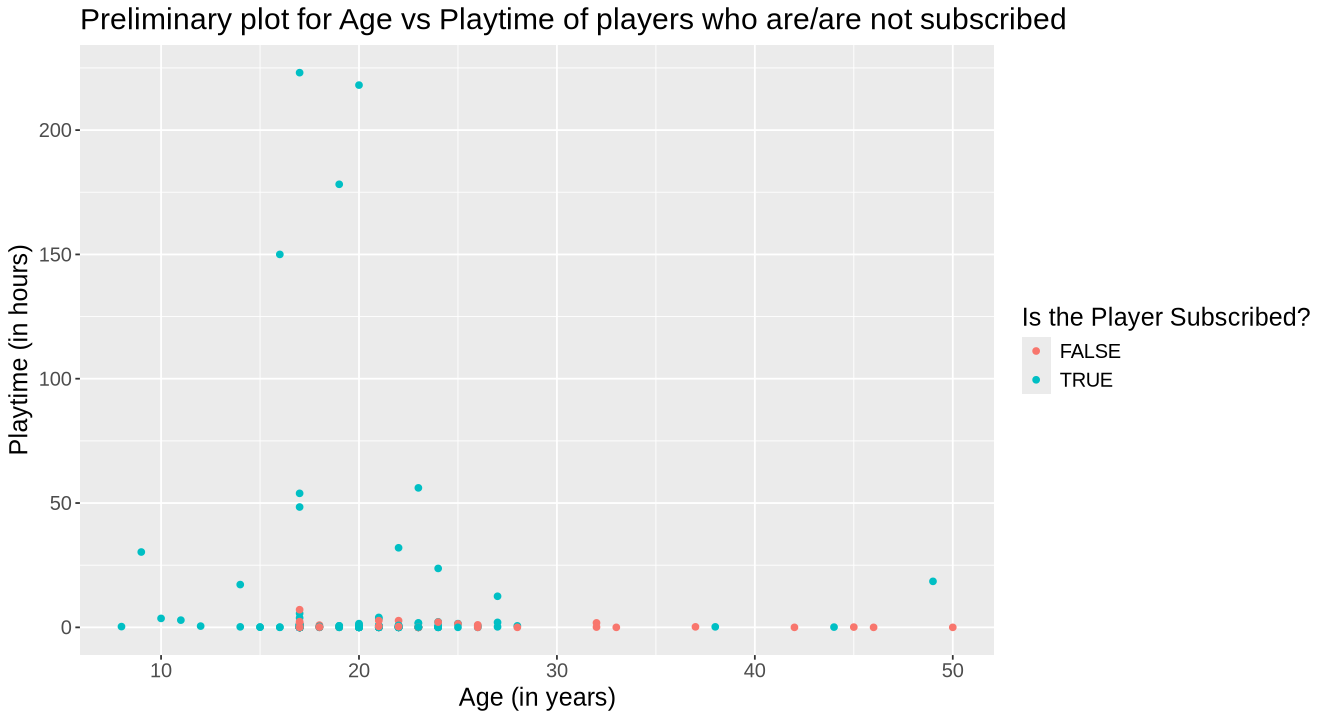

In [6]:
options(repr.plot.width = 11, repr.plot.height = 6)

# Next, we generated a plot to analyze how age and played hours contribute to subscription behaviour of players:
prelim_plot <- ggplot(players_data, aes(x = age, y = played_hours, color = subscribe)) + 
    geom_point() + 
    labs(x = "Age (in years)", 
         y = "Playtime (in hours)", 
         color = "Is the Player Subscribed?", 
         title = "Preliminary plot for Age vs Playtime of players who are/are not subscribed") +
    theme(text = element_text(size = 15))
prelim_plot

Figure 7: Visualization

This graph shows that unsubscribed players (red) tend to be older and play less, while subscribed players (teal) have a wider spread of age and playtime, with a tendency for longer playtime and younger.

We have verified our earlier summary, seen how outliers may affect the values, and seen the spread of the classes/predictors. We can now continue forward with data analysis.

### Finding the best k value
#### Creating the model
To find the ideal k value for KNN classification (providing highest prediction accuracy):
1. Make a recipe (centering & scaling data) with players_training to predict experience, with age and played_hours as predictors.
2. Create a specification with K-NN, using neighbors = tune() to find the ideal k value.
3. Cross-validation is done with ten folds (vfold_cv, stratifying by experience) on players_training as only splitting the data once makes the results highly dependent on the observations ending in the validation set  (more folds increase the accuracy).
4. Combine the recipe and model into a workflow with tune_grid instead of fit. This worfklow runs cross validation on a range of k-nearest neighbours values that is specified in gridvals.
5. Repeat for each validation set for values of 1 ≤ k ≤ 50.
6. Find the best k value by filtering for accuracy and plotting a line plot with the accuracy estimate on the y-axis and k (neighbors) on the x-axis.
7. Ensure lack of underfitting and overfitting so there is more accuracy than a majority classifier, using our new k.

To ensure reproducibility, use set.seed(1).
 

In [7]:
set.seed(1)

# Standardization recipe
players_recipe <- recipe(subscribe ~ age + played_hours, data = players_training) |>
   step_scale(all_predictors()) |>
   step_center(all_predictors())

# KNN model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

# 10 fold-cross valdiation
players_vfold <- vfold_cv(players_training, v = 10, strata = subscribe)

k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 2))

# Create workflow
knn_results <- workflow() |>
      add_recipe(players_recipe) |>
      add_model(knn_spec) |>
      tune_grid(resamples = players_vfold, grid = k_vals) |>
      collect_metrics() 

accuracies <- knn_results |>
      filter(.metric == "accuracy") 

best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        select(neighbors, mean)
best_k

neighbors mean     
1 19        0.7450916

Figure 8: Best K Value

When selecting the K value, we were looking to get roughly optimal accuracy, where changing the value to a nearby one doesn’t decrease accuracy too much, so that our choice is reliable in the presence of uncertainty, and the cost of training the model is not prohibitive (not selected an excessively large K).

k = 19 provides a 74.51% accuracy. We may confirm this selection by plotting a line graph of accuracy vs k.


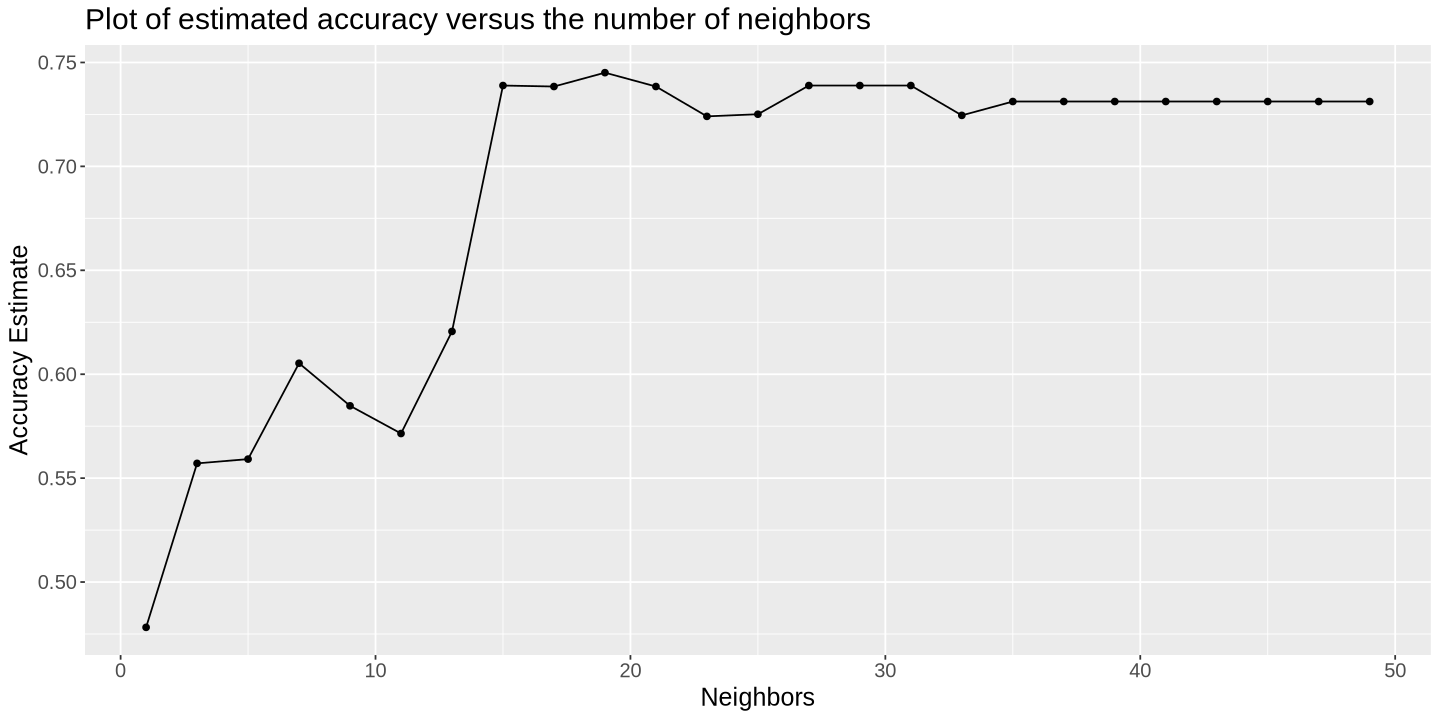

In [8]:
options(repr.plot.width = 12, repr.plot.height = 6)

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate", title = "Plot of estimated accuracy versus the number of neighbors") +
      theme(text = element_text(size = 15))

accuracy_versus_k

Figure 9: Accuracy vs K

From the graph, we can see a peak at k = 19. Thus, we pick k = 19 for easier processing.

#### Comparing to a majority classifier
group_by subscribe and summarize gave us the percentage of the most abundant class.

In [9]:
#Comparing accuracy of classifier with majority classifier
players_proportions <- players_training |>
    group_by(subscribe) |>
    summarize(
        count = n(),
        percentage = n() / nrow(players_training) * 100
      )
players_proportions

subscribe count percentage
1 FALSE      39   26.89655  
2 TRUE      106   73.10345

Figure 10: Comparing Accuracy

Thus, a TRUE subscription status is the majority of the training data (73.10% of all results), and we will consider how this imbalance affects our classifier prediction below. 

#### Building the final model
With k, we can create our final spec with neighbors = 19. We then fit it to players_training.

In [10]:
set.seed(1)

# Final model specification using selected k (19)
final_spec <- nearest_neighbor(weight_func="rectangular", neighbors = 19) |>
    set_engine("kknn") |>
    set_mode("classification")

# Final workflow
final_workflow <- workflow() |>
    add_recipe(players_recipe)|>
    add_model(final_spec) |>
    fit(data = players_training)

final_workflow

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(19,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2551724
Best kernel: rectangular
Best k: 19

Simply using the players_training data, let's evaluate classifier accuracy on unseen data: 

In [11]:
set.seed(1)

# Predict
player_test_predictions <- final_workflow |>
    predict(players_testing) |>
    bind_cols(players_testing)

# Prediction accuracy
player_test_accuracy <- player_test_predictions |> 
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy") 
player_test_accuracy
    
# Confusion matrix to find weak areas of the model 
confusion <- player_test_predictions |>
    conf_mat(truth = subscribe, estimate = .pred_class)
confusion

.metric  .estimator .estimate
1 accuracy binary     0.7346939

          Truth
Prediction FALSE TRUE
     FALSE     0    0
     TRUE     13   36

Figure 11: Confusion Matrix without Oversampling

Although the accuracy is fairly reasonable (73.47%), we can see from the confusion matrix that our classifier currently ALWAYS predicts that the player is subscribed (TRUE), or a false positive. This is due to the imbalanced classes, with the majority of the data points being TRUE. Thus, we rebalanced the data by oversampling the rare class (FALSE) using the upsample function. 

In [12]:
library(themis)

ups_recipe <- recipe(subscribe ~ age + played_hours, data = players_training) |>
  step_upsample(subscribe, over_ratio = 1, skip = FALSE) |>
  prep()

ups_recipe

upsampled_players <- bake(ups_recipe, players_training)

upsampled_players |>
  group_by(subscribe) |>
  summarize(n = n())



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 2



── Training information 

Training data contained 145 data points and no incomplete rows.



── Operations 

• Up-sampling based on: subscribe | Trained



subscribe n  
1 FALSE     106
2 TRUE      106

Figure 12: Upsampled Data

Using this upsampled data, we reselect the ideal k value accordingly. 

In [13]:
set.seed(1)

# Standardization recipe
players_recipe <- recipe(subscribe ~ age + played_hours, data = upsampled_players) |>
   step_scale(all_predictors()) |>
   step_center(all_predictors())

# KNN model specification
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

# 10 fold-cross valdiation
players_vfold <- vfold_cv(players_training, v = 10, strata = subscribe)

k_vals <- tibble(neighbors = seq(from = 1, to = 50, by = 2))

# Create workflow
knn_results <- workflow() |>
      add_recipe(players_recipe) |>
      add_model(knn_spec) |>
      tune_grid(resamples = players_vfold, grid = k_vals) |>
      collect_metrics() 

accuracies <- knn_results |>
      filter(.metric == "accuracy") 

best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        select(neighbors, mean)
best_k

neighbors mean     
1 19        0.7450916

Figure 13: New k value selection 

#### Checking for over/underfitting
Although the model now works, we must still check if it over/underfits. We must visualize the regions that the model has assigned to each class. Doing either would suggest unreliability when using new data to make predictions.

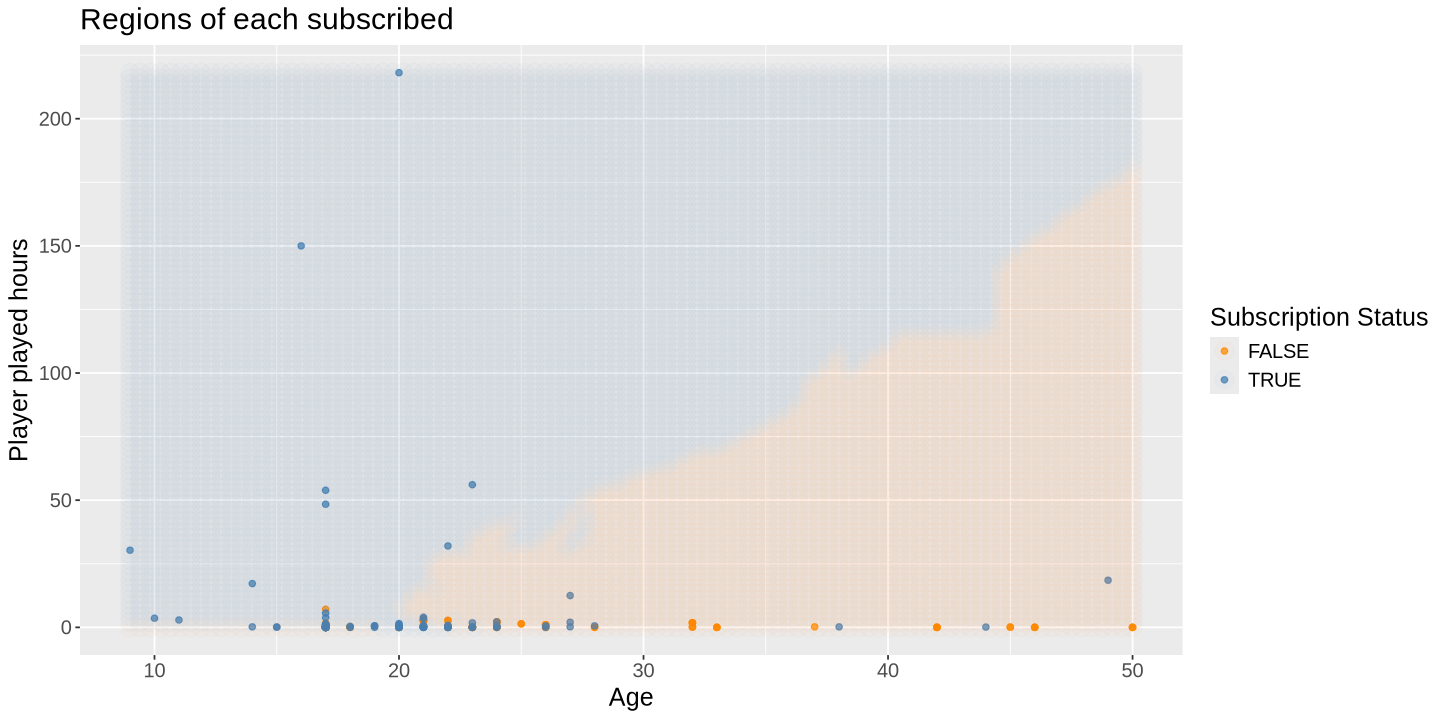

In [14]:
set.seed(1)

# Final model specification using selected k (19)
final_spec <- nearest_neighbor(weight_func="rectangular", neighbors = 19) |>
    set_engine("kknn") |>
    set_mode("classification")

# Final workflow
final_workflow <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(final_spec) |>
    fit(data = upsampled_players)

#Graph with coloured background to check for overfitting/underfitting
age_grid <- seq(min(upsampled_players$age), 
                max(upsampled_players$age), 
                length.out = 100)

hours_grid <- seq(min(upsampled_players$played_hours), 
                max(upsampled_players$played_hours), 
                length.out = 100)

asgrid <- as_tibble(expand.grid(age = age_grid, 
                                played_hours = hours_grid))

knnPredGrid <- predict(final_workflow, asgrid)

prediction_table <- bind_cols(knnPredGrid, asgrid) |>
                    rename(subscribe = .pred_class)


wkflw_plot <- ggplot() + 
                geom_point(data = upsampled_players, 
                mapping = aes(x = age, y = played_hours, color = subscribe), 
                alpha = 0.75) +
                geom_point(data = prediction_table, 
                           mapping = aes(x = age, 
                           y = played_hours, 
                           color = subscribe), 
                           alpha = 0.02, 
                           size = 5) +
                labs(x = "Age", y = "Player played hours", 
                     color = "Subscription Status", 
                     title = "Regions of each subscribed") +
                scale_color_manual(values = c("darkorange", "steelblue")) +
                theme(text = element_text(size = 15))

wkflw_plot

Figure 14: Regions graphed

The graph shows that the classifier does not underfit nor overfit. 

### Classifier evaluation
#### Accuracy and confusion matrix
Evaluate the trained model on the testing set to see the classifier performance on unseen data. We use players_testing to see the accuracy with metrics and its confusion matrix (conf_mat).

In [15]:
set.seed(1)

# Predict
player_test_predictions <- final_workflow |>
    predict(players_testing) |>
    bind_cols(players_testing)

# Prediction accuracy
player_test_accuracy <- player_test_predictions |> 
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy") 
player_test_accuracy
    
# Confusion matrix to find weak areas of the model 
confusion <- player_test_predictions |>
    conf_mat(truth = subscribe, estimate = .pred_class)
confusion

.metric  .estimator .estimate
1 accuracy binary     0.3673469

          Truth
Prediction FALSE TRUE
     FALSE     6   24
     TRUE      7   12

Figure 15: Confusion Matrix for K-NN Model

Our classifier was 36.73% accurate and labeled 18 out of 49 observations correctly.

### Discussion

#### Summary
We found that age and played hours are not good predictors of newsletter subscription status. Originally, the data always predicted TRUE due to oversampling for the TRUE variable. We then upsampled the data to balance the data for TRUE and FALSE data points. The accuracy for this model was significantly low (around 36.73% accuracy). The low accuracy indicates that the variables we chose, age and played hours, are not good predictors of whether the players subscribed to a game-related newsletter, meaning there is not a strong relationship between them. 

#### Expectations
This outcome was different than what was expected as we expected players with a lower age and more played hours would be more likely to subscribe to the newsletter, when in reality, the age and number of hours the player played were not significantly indicative of subscription status. 

When skimming over the data, we expected that there would be a strong relationship between the variables which could be used to determine the subscription status of a player. The results from our code indicate that using age and played_hours as predictor variables is insufficient when looking to accurately predict subscription status. Since we only used these two variables, outliers further decreased the quality of our model.


#### Finding Impacts
Age and the number of hours played are not good predictors to use when selecting player demographics to target for the advertising and sales of newsletters. 

The UBC research group should consider targeting players beyond their age and played_hours. They should consider in-game behavior, since that would contribute significantly to the data collected and may provide more meaningful data for player engagement. Experience could also be an important factor for determining subscription status. 

#### Future Questions
This leads us to question whether other variables are better predictors of newsletter subscription status. Variables such as gender or experience can be tested with the same general question and a different method of predicting their relationship to subscriptions. Another question is whether another method of prediction, such as clustering, would be more accurate when predicting whether age and played hours have an impact on player subscription. 



### References
Lee, T. T., Trevor Campbell, and Melissa. (n.d.). Data science. Retrieved from https://datasciencebook.ca/

Plaicraft. (n.d.). Retrieved from https://plaicraft.ai/

